**this version code trying to tokenize the keyword and categorized them for future analysis**
**Starting from the csv file download from 


In [1]:
# import the necessary libraries
import pandas as pd
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import pandas_datareader.data as web
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsRegressor
sns.set(style="whitegrid")

## Import and Process Tweet data

1. Import Dataset from 'data/trump-tweets-11-18-2019.csv'

2. Change the data type of created_at to datetime.date

3. Restrict the dataset to original tweet only

4. Group by created_at to aggregate all tweets in a day to a single datum point.

5. Sort the Tweet data with a descending date order 

In [2]:
#get the tweet data from downloaded data

df_tweets = pd.read_csv('data/trump-tweets-11-18-2019.csv')
df_tweets['created_at'] =  pd.to_datetime(df_tweets['created_at']).dt.date
df_tweets['trump_tweet_cnt'] =[1 if reFlag ==False else 0 for reFlag in df_tweets['is_retweet'].values]
df_tweets['trump_retweet_cnt'] =[0 if  reFlag ==False else 1 for reFlag in df_tweets['is_retweet'].values]
df_tweets_cleaned = df_tweets.groupby('created_at', as_index = False).agg({
    'trump_tweet_cnt': 'sum',
    'trump_retweet_cnt': 'sum',
    'retweet_count': 'sum',
    'favorite_count': 'sum'
})

df_tweets_cleaned= df_tweets_cleaned.sort_values('created_at',ascending=False)
df_tweets_cleaned.head()

,created_at,trump_tweet_cnt,trump_retweet_cnt,retweet_count,favorite_count
1018,2019-11-18,3,0,50079,179218
1017,2019-11-17,36,15,666343,1668991
1016,2019-11-16,14,11,414895,932464
1015,2019-11-15,19,24,733886,1313131
1014,2019-11-14,13,21,444871,988437


## Import and Process Market data

1. Create a method called ImportData that takes stock code, databse, start_time and end_time and output a dataset that has columns: high,low,open,close,volume,adj_close,percent_change,rise and Date. Details are described in the method

2. Create SPX dataset



,High,Low,Open,Close,Volume,Adj Close,Percent_change,Rise
count,714.000000,714.000000,714.000000,714.000000,7.140000e+02,714.000000,714.000000,714.000000
mean,2703.280097,2679.821904,2692.149145,2692.359538,3.526405e+09,2692.359538,0.010883,0.546218
std,208.661151,206.241855,207.532085,207.366852,5.891733e+08,207.366852,0.694201,0.498208
min,2271.780029,2257.020020,2267.780029,2265.199951,1.349780e+09,2265.199951,-3.873729,0.000000
25%,2509.337463,2495.317566,2501.407532,2506.699951,3.199362e+09,2506.699951,-0.221172,0.000000
50%,2733.034912,2703.029907,2718.645020,2719.250000,3.448825e+09,2719.250000,0.045254,1.000000
75%,2872.892456,2850.987610,2858.637451,2859.260010,3.772742e+09,2859.260010,0.343178,1.000000
max,3127.639893,3113.469971,3127.449951,3122.030029,7.609010e+09,3122.030029,4.425498,1.000000


//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


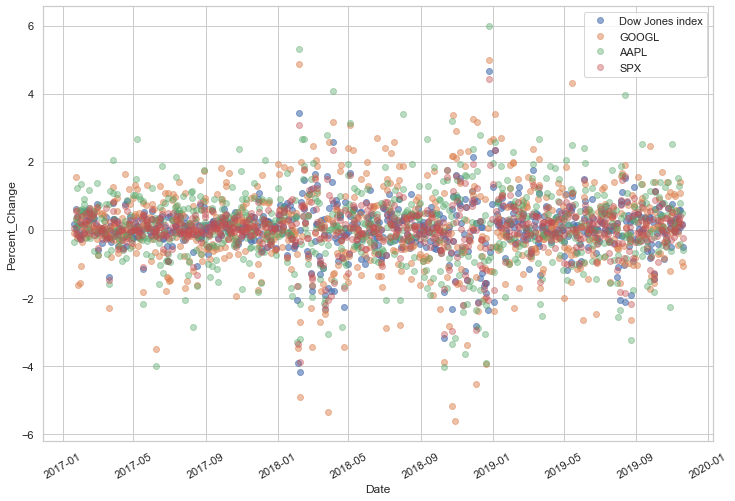

In [3]:

def ImportData(name = "^DJI",source='yahoo',start =datetime.date(2017,1,20), end = datetime.date(2019,11,18) ):
    '''
    This function takes a ticker symbol from a financial data source (yahoo as default), gathering
    daily data from a range start to end.
    
    #### input variables ####
    
        name: the ticker symbol of the stock/index

        source: financial database

        start: starting time of the stock data that the user requests

        end: ending time of the stock data that the user requests 
    
    #### output ####
    
        df: a data frame includes high,low,open,close,volume,adj close, percent_change
    
    ## Attributes ##
    
        high: highest price during the day

        low: lowest price during the day

        open: opening price at 9:30 am

        close: closing price at 4:00 pm

        volume: amount of trading that day

        adj close: I don't really know

        percent_change: (close-open)/open
        
        Rise (categorical): if percent_change > 0
        
        Date: the date

    #desired attributes (not included yet)#
    
        volatility during a specific period

        earning date: categorical variable telling whether the date is an earning date or not

        special occasion: whether some events happen at that day (e.g. Apple publish new iphone)\
        
        Drastic_Rise: rise percentage exceeds mean change % by two std
        
        Drastic_Fall: fall percentage exceeds mean change % by two std
    
    '''

    df = web.DataReader(name,source,start,end)
    df['Percent_change'] = (df.Close-df.Open)/df.Open*100
    df['Date'] = df.index
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    
    #Change index name to avoid confusion
    df.index.name = "Index"
    
    #sort df according to Date
    df = df.sort_values('Date',ascending=False)

    ### Define the 'Rise' attribute ###
    rise_array = []
    for i in range(len(df)):
        if df.iloc[i]['Percent_change']>0:
            rise_array.append(1)
        else:
            rise_array.append(0)
    df['Rise'] = rise_array
        
    return df

DJI_data = ImportData('^DJI','yahoo')
AAPL_data = ImportData('AAPL','yahoo')
GOOGL_data = ImportData('GOOGL','yahoo')
df_SPX = ImportData("^GSPC",'yahoo')

display(df_SPX.describe())

fig,ax = plt.subplots(1,1,figsize=(12,8))

ax.plot(DJI_data.Date,DJI_data.Percent_change,'o',label = "Dow Jones index",alpha = 0.6)
ax.plot(GOOGL_data.Date,GOOGL_data.Percent_change,'o',label = 'GOOGL',alpha = 0.5)
ax.plot(AAPL_data.Date,AAPL_data.Percent_change,'o',label = 'AAPL',alpha = 0.4)
ax.plot(df_SPX.Date,df_SPX.Percent_change,'o',label = 'SPX',alpha = 0.4)
ax.set_xlabel("Date")
ax.set_ylabel("Percent_Change")
ax.legend()
plt.xticks(rotation = 30)
plt.show()


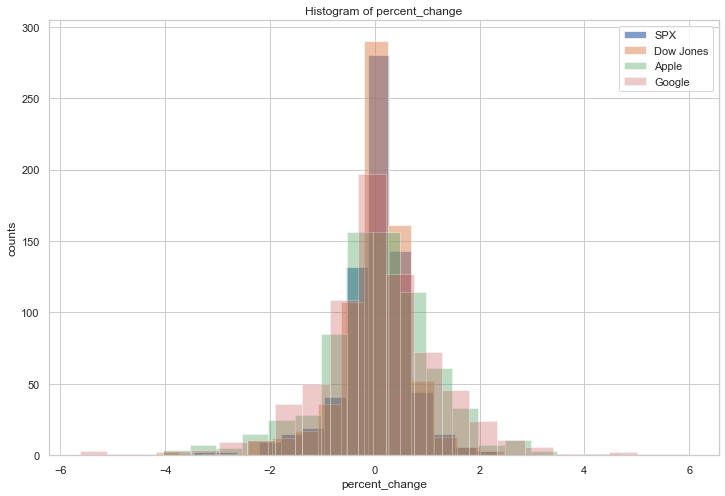

In [4]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(df_SPX.Percent_change,bins=20,label = 'SPX',alpha=0.7)
ax.hist(DJI_data.Percent_change,bins=20,label = 'Dow Jones',alpha=0.5)

ax.hist(AAPL_data.Percent_change,bins=20,label = 'Apple',alpha = 0.4)

ax.hist(GOOGL_data.Percent_change,bins=20,label = 'Google',alpha = 0.3)

ax.set_xlabel('percent_change')
ax.set_ylabel('counts')
ax.legend()
ax.set_title('Histogram of percent_change')
plt.show()

## Combine Tweet and Market Data into a Single Dataset

1. Create a column named trade_date_flag in tweet dataset to indicate whether the date is a trade-day or not

2. Create a combined dataset df_cbm based on df_SPX and add three columns:`trump_tweet_cnt`,`retweet_count`, and `favorite_count`, which indicate the number of tweets Trump tweeted, the number of retweets of Trump's tweets and the number of likes in a particular day



In [5]:
#df_tweets_cleaned['trade_date_flag']=[1 if dt in (df_SPX['Date'].values) else 0 for dt in df_tweets_cleaned['created_at']]


df_tweets_cleaned['trade_date_flag'] = [1 if dt in df_SPX['Date'].values else 0 for dt in df_tweets_cleaned['created_at']]

df_cbm = df_SPX.copy()
df_cbm['trump_tweet_cnt'] = [df_tweets_cleaned.loc[df_tweets_cleaned['created_at']==dt]['trump_tweet_cnt'].values[0] if dt in (df_tweets_cleaned['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['retweet_count'] = [df_tweets_cleaned.loc[df_tweets_cleaned['created_at']==dt]['retweet_count'].values[0] if dt in (df_tweets_cleaned['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['favorite_count'] = [df_tweets_cleaned.loc[df_tweets_cleaned['created_at']==dt]['favorite_count'].values[0] if dt in (df_tweets_cleaned['created_at'].values) else 0 for dt in df_SPX['Date'].values]
display(df_cbm.head())
display(df_cbm.describe())

,High,Low,Open,Close,Volume,Adj Close,Percent_change,Date,Rise,trump_tweet_cnt,retweet_count,favorite_count
Index,,,,,,,,,,,,
2019-11-19,3127.639893,3113.469971,3127.449951,3120.179932,3590070000,3120.179932,-0.232458,2019-11-19,0,0,0,0
2019-11-18,3124.169922,3112.060059,3117.909912,3122.030029,3436690000,3122.030029,0.132144,2019-11-18,1,3,50079,179218
2019-11-15,3120.459961,3104.600098,3107.919922,3120.459961,3335650000,3120.459961,0.403487,2019-11-15,1,19,733886,1313131
2019-11-14,3098.199951,3083.260010,3090.750000,3096.629883,3276070000,3096.629883,0.190241,2019-11-14,1,13,444871,988437
2019-11-13,3098.060059,3078.800049,3084.179932,3094.040039,3509280000,3094.040039,0.319699,2019-11-13,1,13,620215,861799


,High,Low,Open,Close,Volume,Adj Close,Percent_change,Rise,trump_tweet_cnt,retweet_count,favorite_count
count,714.000000,714.000000,714.000000,714.000000,7.140000e+02,714.000000,714.000000,714.000000,714.000000,714.000000,7.140000e+02
mean,2703.280097,2679.821904,2692.149145,2692.359538,3.526405e+09,2692.359538,0.010883,0.546218,9.551821,220677.815126,8.066064e+05
std,208.661151,206.241855,207.532085,207.366852,5.891733e+08,207.366852,0.694201,0.498208,6.127969,146725.503616,4.684928e+05
min,2271.780029,2257.020020,2267.780029,2265.199951,1.349780e+09,2265.199951,-3.873729,0.000000,0.000000,0.000000,0.000000e+00
25%,2509.337463,2495.317566,2501.407532,2506.699951,3.199362e+09,2506.699951,-0.221172,0.000000,5.000000,111188.250000,4.535138e+05
50%,2733.034912,2703.029907,2718.645020,2719.250000,3.448825e+09,2719.250000,0.045254,1.000000,9.000000,195229.500000,7.345530e+05
75%,2872.892456,2850.987610,2858.637451,2859.260010,3.772742e+09,2859.260010,0.343178,1.000000,13.000000,292444.750000,1.082758e+06
max,3127.639893,3113.469971,3127.449951,3122.030029,7.609010e+09,3122.030029,4.425498,1.000000,36.000000,789785.000000,2.639593e+06


# EDA and Baseline Model

1. We first perform a scatter plot on all the columns of the combined data frame. At first glance, `high`,`low`,`open`,`close`and `adj close` have some linear relationship with `trump_tweet_cnt`,`retweet_count`, and `favorite_count`. Other columns that are not directly reflecting the price, such as `volume` and `percent_change` seem to be unrelated to `trump_tweet_cnt`,`retweet_count`, or `favorite_count`. 


2. Therefore, we perform a simple linear regression model using `trump_tweet_cnt`,`retweet_count`, and `favorite_count` as predictors and `high` as response variable and calculate the score. The resulting scores are: training set_score is  0.3568885939125697 and test set score is 0.21461705632672434. These are pretty bad scores, so we will further process the data and then do the fitting. Lasso regularization can be implemented in the future, too.


3. Then we perform a series of k-NN model using `trump_tweet_cnt`,`retweet_count`, and `favorite_count` as predictors and `high` as response variable and calculate the score. The best scores we get is when number of neighbors is 5. The training set_score is  0.5149415011396388. The test set score is 0.21104232921257227

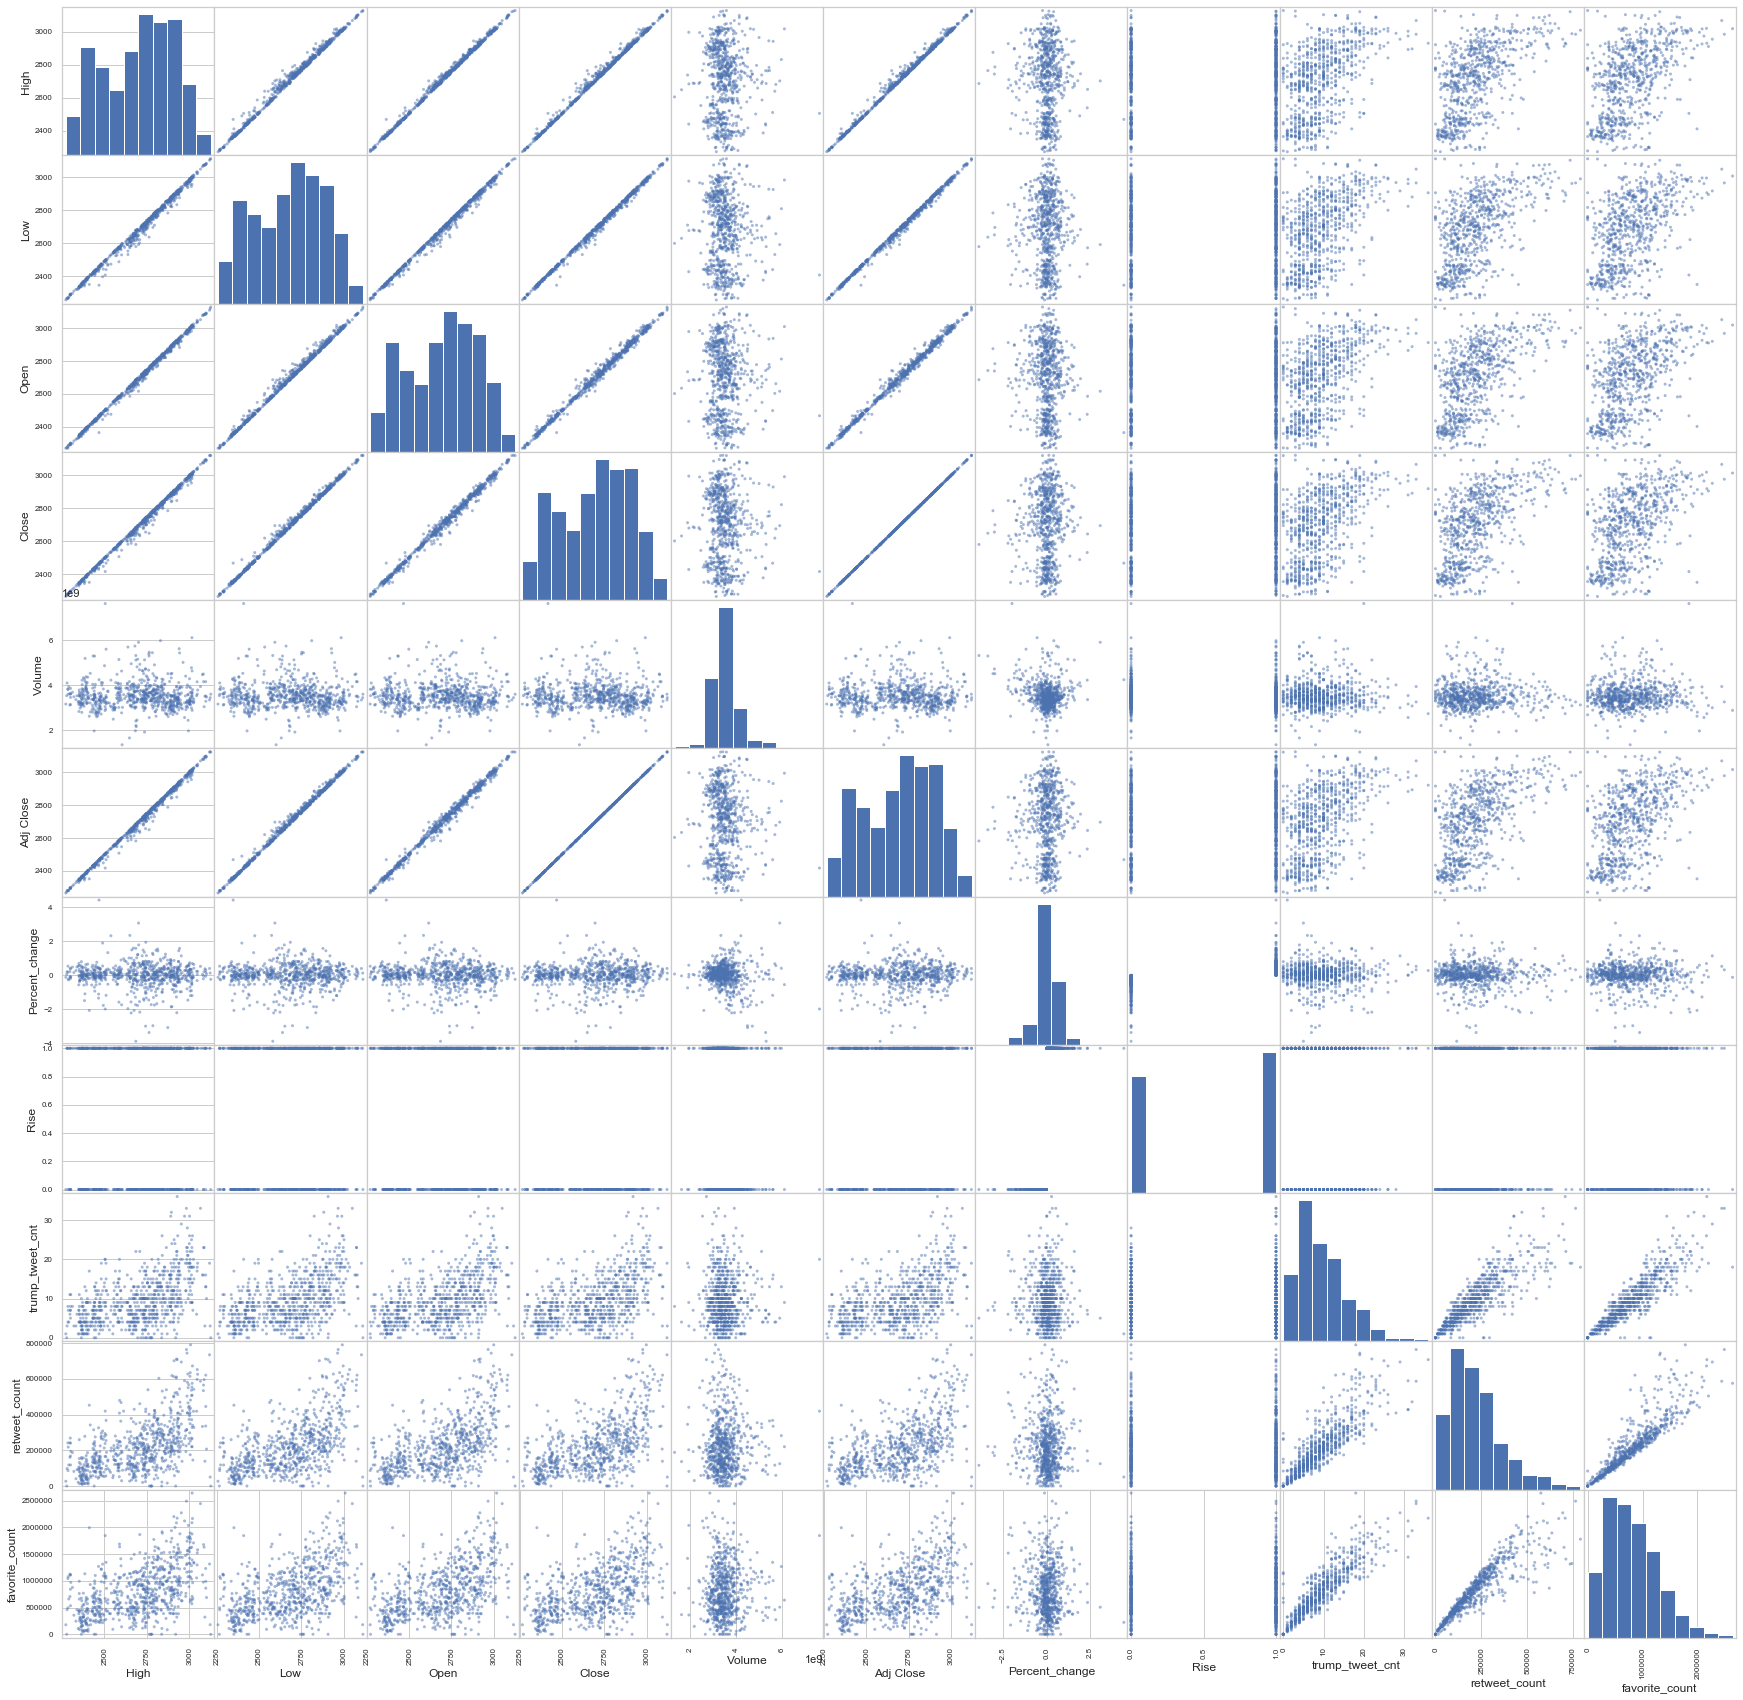

In [6]:
scatter_matrix(df_cbm,figsize=(30,30))
plt.show()

In [7]:
combined_df = pd.merge(left=df_tweets_cleaned, right=df_SPX, how='left', left_on='created_at', right_on='Date')
combined_df.head()

,created_at,trump_tweet_cnt,trump_retweet_cnt,retweet_count,favorite_count,trade_date_flag,High,Low,Open,Close,Volume,Adj Close,Percent_change,Date,Rise
0,2019-11-18,3,0,50079,179218,1,3124.169922,3112.060059,3117.909912,3122.030029,3.436690e+09,3122.030029,0.132144,2019-11-18,1.0
1,2019-11-17,36,15,666343,1668991,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-16,14,11,414895,932464,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-11-15,19,24,733886,1313131,1,3120.459961,3104.600098,3107.919922,3120.459961,3.335650e+09,3120.459961,0.403487,2019-11-15,1.0
4,2019-11-14,13,21,444871,988437,1,3098.199951,3083.260010,3090.750000,3096.629883,3.276070e+09,3096.629883,0.190241,2019-11-14,1.0


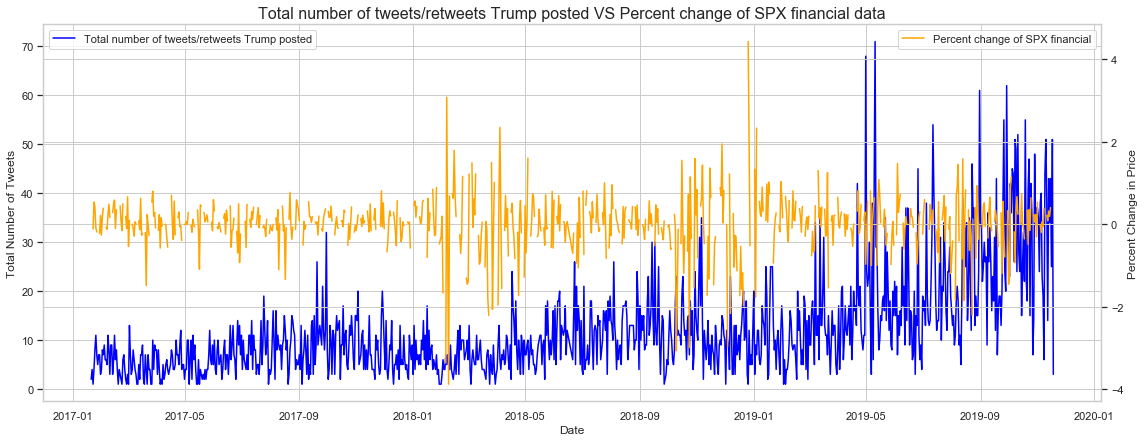

In [8]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(combined_df['created_at'],combined_df['trump_tweet_cnt'] + combined_df['trump_retweet_cnt'], color='blue', label='Total number of tweets/retweets Trump posted')
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Number of Tweets")
plt.legend()
ax2 = ax1.twinx()
ax2.set_ylabel("Percent Change in Price")
ax2.plot(combined_df['created_at'], combined_df['Percent_change'], color='orange', label='Percent change of SPX financial')
fig.tight_layout() 

plt.title('Total number of tweets/retweets Trump posted VS Percent change of SPX financial data', fontsize=16)
plt.legend()
plt.show()

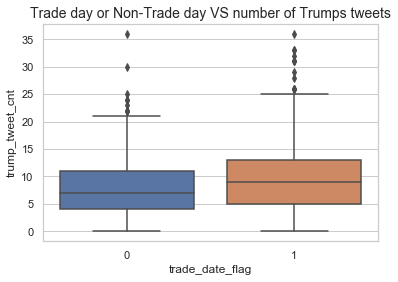

In [9]:
sns.boxplot(x = 'trade_date_flag', y = 'trump_tweet_cnt', data = combined_df)
plt.title('Trade day or Non-Trade day VS number of Trumps tweets', fontsize=14)
plt.show()

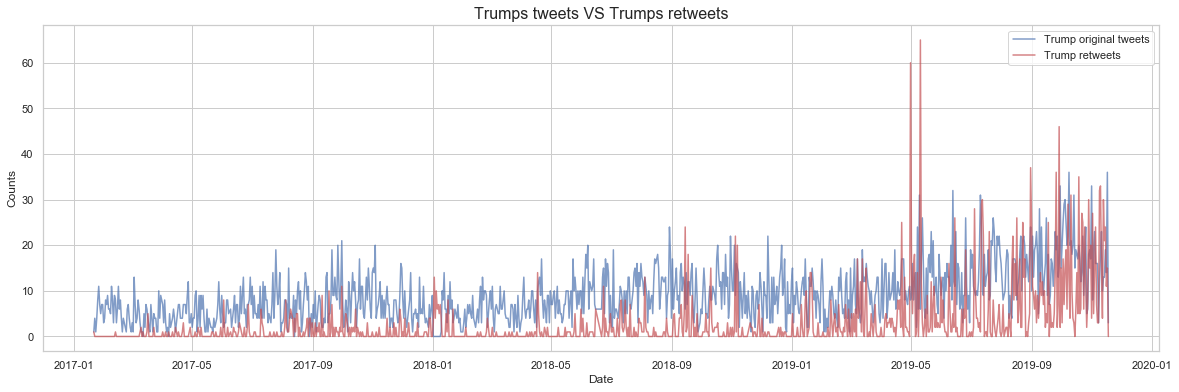

In [10]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(combined_df['created_at'], combined_df['trump_tweet_cnt'], color='b',alpha=0.7, label='Trump original tweets')
ax.plot(combined_df['created_at'], combined_df['trump_retweet_cnt'], color='r', alpha=0.7, label='Trump retweets')
ax.set_xlabel("Date")
ax.set_ylabel("Counts")
plt.title('Trumps tweets VS Trumps retweets', fontsize=16)
plt.legend()
plt.show()

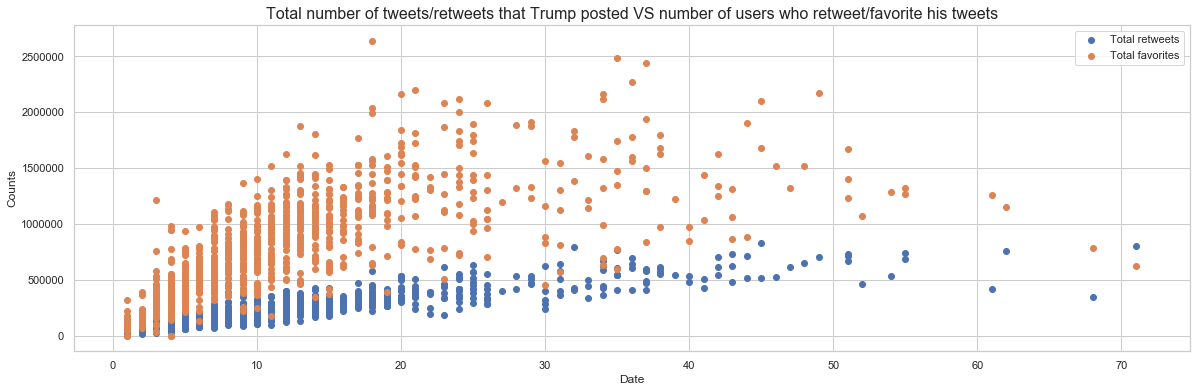

In [11]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['trump_tweet_cnt'] + combined_df['trump_retweet_cnt'], combined_df['retweet_count'], label="Total retweets")
ax.scatter(combined_df['trump_tweet_cnt'] + combined_df['trump_retweet_cnt'], combined_df['favorite_count'], label="Total favorites")
ax.set_xlabel("Date")
ax.set_ylabel("Counts")
plt.title('Total number of tweets/retweets that Trump posted VS number of users who retweet/favorite his tweets', fontsize=16)
plt.legend()
plt.show()

In [12]:
x = df_cbm[['trump_tweet_cnt','retweet_count','favorite_count']]
y = df_cbm['High']

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

reg = LinearRegression().fit(X_train,y_train)
train_score = reg.score(X_train,y_train)
test_score = reg.score(X_test,y_test)
print("The training set_score is ",train_score,". The test set score is",test_score)

The training set_score is  0.31001967370133954 . The test set score is 0.3596935088561922


In [13]:
k_list = [1,2,3,5,6,7,8,10,20,25]
for k in k_list:
    kNN = KNeighborsRegressor(n_neighbors = k).fit(X_train,y_train)

    train_score = kNN.score(X_train,y_train)
    test_score = kNN.score(X_test,y_test)

    print("The number of neighbors is",k,"The training set_score is ",train_score,". The test set score is",test_score)

The number of neighbors is 1 The training set_score is  0.9838190098255496 . The test set score is -0.31207893645077656
The number of neighbors is 2 The training set_score is  0.6768151976612544 . The test set score is 0.11671280617384938
The number of neighbors is 3 The training set_score is  0.574791822820186 . The test set score is 0.24967364333729047
The number of neighbors is 5 The training set_score is  0.495328928484681 . The test set score is 0.2793987534142749
The number of neighbors is 6 The training set_score is  0.47008522078723947 . The test set score is 0.2929732039126379
The number of neighbors is 7 The training set_score is  0.4506475828160147 . The test set score is 0.3124598363987361
The number of neighbors is 8 The training set_score is  0.4440788573930198 . The test set score is 0.30710837053833184
The number of neighbors is 10 The training set_score is  0.4206979032958488 . The test set score is 0.2957167379447707
The number of neighbors is 20 The training set_scor

# Future Work

1. The baseline model clearly gives terrible fitting. The failure is due to the lack of proper predictors. The number of tweets by Trump does not mean much to the market; rather, it's the content in those tweets that matters more. A simple modification on the current dataset is to have a column named ave_retweet or ave_favorite, whose value is `retweet_count`/`trump_tweet_cnt` or `favorite_count`/`trump_tweet_cnt`. This column would reflect the importance of the tweets at a particular day. We expect important tweets have more influence on the market.

2. An important task to do is to categorize the tweets based on the content. Possible categories are, whether a tweet mentions market(e.g. mentions a company's name or an industry), whether a tweet mentions trade war, whether a tweet expresses positive or negative attitude, whether a tweet uses strong language or not. After categorization, we may use models such as decision tree to find out the most important features that influence the market.

3. We will find out the most frequent phrases that Trump uses in the tweets and check how the appearance of these phrases influence market behavior.

4. We can include more features into the market data. For example, we can have a column named big_change, indicating whether the stock/index experiences a change that is way larger than $2*std$. The new features
